# Approximate Inference in Bayesian Deep Learning: Getting Started in JAX

In this colab we will walk you through downloading the data, running your method and generating a submission for our NeurIPS 2021 competition. In this colab we use the JAX framework. For PyTorch see ...

Useful references:
- [Competition website](https://izmailovpavel.github.io/neurips_bdl_competition/)
- [Efficient implementation of several baselines in JAX](https://github.com/google-research/google-research/tree/master/bnn_hmc)
- [Submission platform](https://competitions.codalab.org/competitions/33512?secret_key=10f23c1f-9c86-4a7a-8406-d85b0a0713f2)


## Setting up colab

Colab provides an easy-to-use environment for working on the competition with access to free computational resources. However, you should also be able to run this notebook locally after installing the required dependencies. If you use colab, please select a `GPU` runtime type.

## Preparing the data


In [ ]:
# uncomment order to re-install the starter kit
# !rm -rf neurips_bdl_starter_kit

!git clone https://github.com/izmailovpavel/neurips_bdl_starter_kit
! pip install git+https://github.com/deepmind/dm-haiku
! pip install optax

import sys
import math
import jax
import tensorflow as tf
import optax
import matplotlib
import numpy as onp
from jax import numpy as jnp
from matplotlib import pyplot as plt

sys.path.append("neurips_bdl_starter_kit")
import jax_models as models

Cloning into 'neurips_bdl_starter_kit'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 17 (delta 4), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (17/17), done.
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-doju5epq
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-doju5epq
  Created wheel for dm-haiku: filename=dm_haiku-0.0.5.dev0-cp37-none-any.whl size=530560 sha256=a5c7af32edd9766d8b2ae449c01e53cb0c4ea572abfc71414a56c01247ad17bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-9hg3_51l/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku
     |████████████████████████████████| 122kB 6.5MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 


We provide the datasets used in this competition in a public Google Cloud Storage bucket in the `.csv` format. Here we download the data:

You can also download the data to your computer by clicking these links:
- [CIFAR-10 train features](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_train_x.csv)
- [CIFAR-10 train labels](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_train_y.csv)
- [CIFAR-10 test features](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_test_x.csv)
- [CIFAR-10 test labels](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_test_y.csv)

In [ ]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/cifar10_*.csv .

Copying gs://neurips2021_bdl_competition/cifar10_test_x.csv...
Copying gs://neurips2021_bdl_competition/cifar10_test_y.csv...
Copying gs://neurips2021_bdl_competition/cifar10_train_y.csv...
Copying gs://neurips2021_bdl_competition/cifar10_train_x.csv...
\ [4/4 files][  4.4 GiB/  4.4 GiB] 100% Done  74.7 MiB/s ETA 00:00:00           
Operation completed over 4 objects/4.4 GiB.                                      


We can now read the data and convert it into numpy arrays. This cell may take several minutes to run.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


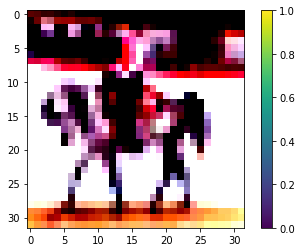

In [ ]:
x_train = onp.loadtxt("cifar10_train_x.csv")
y_train = onp.loadtxt("cifar10_train_y.csv")
x_test = onp.loadtxt("cifar10_test_x.csv")
y_test = onp.loadtxt("cifar10_test_y.csv")

x_train = x_train.reshape((len(x_train), 32, 32, 3))
x_test = x_test.reshape((len(x_test), 32, 32, 3))

plt.imshow(x_train[0])
plt.colorbar()

Finally, we define a `tf.data.Dataset` for the train and test datasets.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

## Model and losses

We provide the code for all the models used in the competition in the `neurips_bdl_starter_kit/jax_models.py` module. Here, we will load a ResNet-20 model with filter response normalization (FRN) and swish avtivations. The models are implemented in [`haiku`](https://github.com/deepmind/dm-haiku).

We also define the cross-entropy likelihood (`log_likelihood_fn`) and Gaussian prior (`log_prior_fn`), and the corresponding posterior log-density (`log_posterior_fn`). The `log_posterior_wgrad_fn` computes the posterior log-density and its gradients with respect to the parameters of the model.

The `evaluate_fn` function computes the accuracy and predictions of the model on a given dataset; we will use this function to generate the predictions for our submission.

In [ ]:
net_apply, net_init = models.get_model("resnet20_frn_swish", data_info={"num_classes": 10})
prior_variance = 5.

def log_likelihood_fn(params, batch, is_training=True):
    """Computes the log-likelihood."""
    x, y = batch
    logits = net_apply(params, None, x, is_training)
    num_classes = logits.shape[-1]
    labels = jax.nn.one_hot(y, num_classes)
    softmax_xent = jnp.sum(labels * jax.nn.log_softmax(logits))

    return softmax_xent


def log_prior_fn(params):
    """Computes the Gaussian prior log-density."""
    n_params = sum([p.size for p in jax.tree_leaves(params)])
    exp_term = sum(jax.tree_leaves(jax.tree_map(
        lambda p: (-p**2 / (2 * prior_variance)).sum(), params)))
    norm_constant = -0.5 * n_params * jnp.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant


def log_posterior_fn(params, batch, is_training=True):
    log_lik = log_likelihood_fn(params, batch, is_training=True)
    log_prior = log_prior_fn(params)
    return log_lik + log_prior
    # return log_lik


@jax.jit
def get_accuracy_fn(batch, params):
    x, y = batch
    logits = net_apply(params, None, x, False)
    probs = jax.nn.softmax(logits, axis=1)
    preds = jnp.argmax(logits, axis=1)
    accuracy = (preds == y).mean()
    return accuracy, probs


def evaluate_fn(dataset, params):
    sum_accuracy = 0
    all_probs = []
    for x, y in dataset:
        x, y = jnp.asarray(x), jnp.asarray(y)
        batch_accuracy, batch_probs = get_accuracy_fn((x, y), params)
        sum_accuracy += batch_accuracy.item()
        all_probs.append(onp.asarray(batch_probs))
    all_probs = jnp.concatenate(all_probs, axis=0)
    return sum_accuracy / len(dataset), all_probs


log_posterior_wgrad_fn = jax.jit(jax.value_and_grad(log_posterior_fn, argnums=0))

Now we can initialize the parameters of the model. 

In [ ]:
seed = jax.random.PRNGKey(0)
key, net_init_key = jax.random.split(seed, 2)
init_data, _ = next(iter(train_dataset))
init_data = jnp.asarray(init_data)
params = net_init(net_init_key, init_data, True)

## Optimizer

In this colab we will train an approximate maximum-a-posteriori (MAP) solution as our submission for simplicity. You can find efficient implementations of more advanced baselines [here](https://github.com/google-research/google-research/tree/master/bnn_hmc).

We will use SGD with momentum. You can adjust the hyper-parameters or switch to a different optimizer by changing the code below.

`update_fn` implements a single optimization step on a mini-batch of data.

In [ ]:
batch_size = 100
test_batch_size = 1000
num_epochs = 5
shuffle_buffer_size = 1000
momentum_decay = 0.9
init_lr = 1.e-3

train_dataset_batched = train_dataset.shuffle(shuffle_buffer_size, reshuffle_each_iteration=True)
train_dataset_batched = train_dataset_batched.batch(batch_size)
test_dataset_batched = test_dataset.batch(test_batch_size)

epoch_steps = len(train_dataset_batched)
total_steps = epoch_steps * num_epochs



def lr_schedule(step):
    t = step / total_steps
    return 0.5 * init_lr * (1 + jnp.cos(t * onp.pi))

optimizer = optax.chain(
    optax.trace(decay=momentum_decay, nesterov=False),
    optax.scale_by_schedule(lr_schedule))
opt_state = optimizer.init(params)


@jax.jit
def update_fn(batch, params, opt_state):
  x, y = batch
  loss, grad = log_posterior_wgrad_fn(params, (x, y))
  updates, new_opt_state = optimizer.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state, loss

## Training

We will run training for 5 epochs, which can take several minutes to complete. Note that in order to achieve good results you need to run the method substantially longer and tune the hyper-parameters.

In [ ]:
for epoch in range(num_epochs):
    sum_loss = 0.
    for x, y in train_dataset_batched:
        x, y = jnp.asarray(x), jnp.asarray(y)
        params, opt_state, loss = update_fn((x, y), params, opt_state)
        sum_loss += loss
    
    test_acc, all_test_probs = evaluate_fn(test_dataset_batched, params)
    print("Epoch {}".format(epoch))
    print("\tAverage loss: {}".format(sum_loss / epoch_steps))
    print("\tTest accuracy: {}".format(test_acc))

all_test_probs = onp.asarray(all_test_probs)

Epoch 0
	Average loss: -472673.96875
	Test accuracy: 0.2943000137805939
Epoch 1
	Average loss: -472567.4375
	Test accuracy: 0.3136000126600266
Epoch 2
	Average loss: -472545.71875
	Test accuracy: 0.41730002462863924
Epoch 3
	Average loss: -472527.21875
	Test accuracy: 0.49570002853870393
Epoch 4
	Average loss: -472506.9375
	Test accuracy: 0.5400000214576721


## Preparing the submission

Once you run the code above, `all_test_probs` should contain an array of size `10000 x 10` where the rows correspond to test datapoints and columns correspond to classes.

In [ ]:
all_test_probs.shape

(10000, 10)

Now, we need to save the array as `cifar10_probs.csv` and create a zip archive with this file.

In [ ]:
onp.savetxt("cifar10_probs.csv", all_test_probs, delimiter=',')

!zip submission.zip cifar10_probs.csv

updating: cifar10_probs.csv (deflated 56%)


Finally, you can download the submission by running the code below. If the download doesn't start, check that your browser did not block it automatically.

In [ ]:
from google.colab import files
files.download('submission.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can head over to the [submission system](https://competitions.codalab.org/competitions/33512?secret_key=10f23c1f-9c86-4a7a-8406-d85b0a0713f2#participate) and upload your submission. Good luck :)